# Segmentazione di edifici da immagini satellitari e classificazione del contesto urbano: notebook per training del modello di riconoscimento

*Progetto di Visione Artificiale e Riconoscimento 2024/2025*

- **Nome:** Pablo Sebastian
- **Cognome:** Vargas Grateron
- **Email:** pablo.vargasgrateron@studio.unibo.it

Questo progetto si concentra sulla segmentazione di edifici da immagini satellitari e sulla classificazione del contesto urbano. Utilizza tecniche di deep learning per analizzare immagini aeree e identificare edifici e altre strutture urbane.

Il dataset utilizzato è il dataset [Inria Aerial Image Labeling](https://project.inria.fr/aerialimagelabeling/), che contiene immagini aeree ad alta risoluzione e le relative maschere di segmentazione degli edifici.

> Assicurati di scaricare il dataset prima di eseguire il notebook e di avere al meno 50 GB di spazio libero su disco.

## Librerie e percorsi dei dataset

Il codice contenuto nelle seguenti celle importa le librerie necessarie e definisce i percorsi per i dataset utilizzati nel progetto.

> Assicurati di avere installato le librerie richieste contenute nel file `requirements.txt` prima di eseguire il notebook.

In [1]:
import os, time, random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [2]:
print("TF version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TF version: 2.19.0
Num GPUs Available:  1


Per la prossima cella, assicurati di avere i seguenti percorsi impostati correttamente:
- `PATH_DATASET_DIR`: percorso alla cartella principale dove sono memorizzati i dataset.
- `PATH_DATASET`: percorso alla cartella contenente i dataset originali.
- `PATH_PROCESSED_DATASET`: percorso alla cartella dove saranno memorizzati i dataset elaborati.
- `PATH_MODEL`: percorso alla cartella dove sarà memorizzato il modello addestrato.

In [2]:
PATH_DATASET_DIR = Path("../../dataset")
PATH_DATASET = PATH_DATASET_DIR / "original"
PATH_PROCESSED_DATASET = PATH_DATASET_DIR / "processed"

PATH_TRAIN_DATASET = PATH_DATASET / "train"
PATH_TEST_DATASET = PATH_DATASET / "test"

PATH_TRAIN_DATASET_PROCESSED = PATH_PROCESSED_DATASET / "train"
PATH_TEST_DATASET_PROCESSED = PATH_PROCESSED_DATASET / "test"

PATH_MODEL = Path("model")

## Preparazione del dataset

###  Divisione in segmenti

Per arricchire il dataset e migliorare le prestazioni del modello, le immagini e le maschere vengono suddivise in segmenti più piccoli. Questo processo consente di gestire meglio le immagini ad alta risoluzione e di aumentare la varietà dei dati di addestramento.

La seguente cella è utilizzata per generare patch dalle immagini nella cartella specificata nel formato png.

In [3]:
def extract_patches_from_folder(input_folder: Path, output_folder: Path, patch_size=500):
    os.makedirs(output_folder, exist_ok=True)
    image_files = list(input_folder.glob("*.tif")) + list(input_folder.glob("*.TIF")) + list(input_folder.glob("*.tiff"))

    count = 0
    for img_path in image_files:
        img = Image.open(img_path)
        width, height = img.size

        for top in range(0, height, patch_size):
            for left in range(0, width, patch_size):
                right = min(left + patch_size, width)
                bottom = min(top + patch_size, height)

                if right - left == patch_size and bottom - top == patch_size:
                    patch = img.crop((left, top, right, bottom))
                    patch_name = f"{img_path.stem}_x{left}_y{top}.png"
                    patch.save(output_folder / patch_name)
                    count += 1

    print(f"Generati {count} patch da {input_folder.name} in {output_folder.name}")

Dato che il dataset contiene 360 immagini di dimensioni 5000x5000 pixel, la suddivisione in segmenti di 500x500 pixel dovrebbe generare 36.000 segmenti per ogni cartella.

> Per modificare la dimensione dei segmenti, puoi cambiare il valore della variabile `PATCH_SIZE` nella cella seguente.

> **Attenzione:** La prossima cella esegue un'operazione di preprocessing che potrebbe richiedere tempo a seconda della dimensione del dataset.

In [4]:
PATCH_SIZE = 500

In [5]:
def has_images(folder: Path):
    return any(folder.glob("*.png"))

if not has_images(PATH_TRAIN_DATASET_PROCESSED / "images"):
    print("Inizio l'estrazione delle patch dalle immagini del train...")
    extract_patches_from_folder(PATH_TRAIN_DATASET / "images", PATH_TRAIN_DATASET_PROCESSED / "images", PATCH_SIZE)
else:
    print("Immagini elaborate del train già esistono.")

if not has_images(PATH_TRAIN_DATASET_PROCESSED / "gt"):
    print("Inizio l'estrazione delle patch dalle immagini GT del train...")
    extract_patches_from_folder(PATH_TRAIN_DATASET / "gt", PATH_TRAIN_DATASET_PROCESSED / "gt", PATCH_SIZE)
else:
    print("Immagini GT elaborate del train già esistono.")

if not has_images(PATH_TEST_DATASET_PROCESSED / "images"):
    print("Inizio l'estrazione delle patch dalle immagini del test...")
    extract_patches_from_folder(PATH_TEST_DATASET / "images", PATH_TEST_DATASET_PROCESSED / "images", PATCH_SIZE)
else:
    print("Immagini elaborate del test già esistono.")

Immagini elaborate del train già esistono.
Immagini GT elaborate del train già esistono.
Immagini elaborate del test già esistono.


Per controllare il corretto funzionamento del codice, puoi eseguire le celle seguenti per visualizzare le prime immagini del dataset originale e quelle elaborate.

In [6]:
def print_specific_image(folder: Path, filename: str):
    img_path = folder / filename
    if img_path.exists():
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{img_path.name} - shape: {img.size}")
        plt.axis('off')
        plt.show()
    else:
        print(f"File {filename} not found in {folder}")

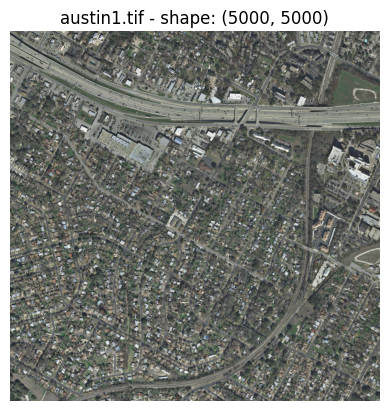

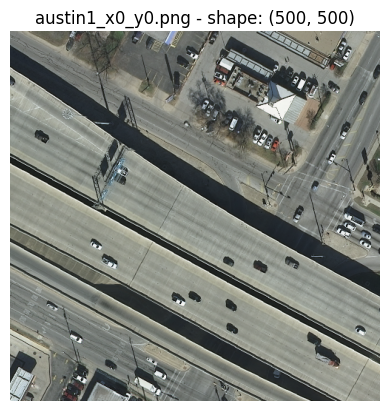

In [7]:
print_specific_image(PATH_TRAIN_DATASET / "images", "austin1.tif")
print_specific_image(PATH_TRAIN_DATASET_PROCESSED / "images", "austin1_x0_y0.png")

## Training

Per questo progetto utilizzeremo la libreria TensorFlow e l'obiettivo è addestrare un modello di segmentazione per identificare gli edifici nelle immagini satellitari.

Come modello di segmentazione, utilizzeremo un'architettura U-Net, che è ampiamente utilizzata per compiti di segmentazione semantica. La U-Net è progettata per lavorare bene con immagini ad alta risoluzione e può essere facilmente adattata per segmentare edifici in immagini satellitari.

### Funzioni per il caricamento delle immagini e delle maschere

La prossima cella definisce funzioni per caricare le immagini del dataset e le relative maschere.

In [ ]:
def load_image_and_mask(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [PATCH_SIZE, PATCH_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [PATCH_SIZE, PATCH_SIZE])
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask

def create_train_val_datasets(image_folder: Path, mask_folder: Path, batch_size, val_split=0.2):
    image_paths = sorted([str(p) for p in image_folder.glob("*.png")])
    mask_paths = sorted([str(p) for p in mask_folder.glob("*.png")])

    train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=val_split, random_state=42
    )

    train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
    train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))
    val_dataset = val_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset

### Architettura del modello

L'architettura del modello U-Net è definita nella cella seguente. L'architettura è composta da:
- Un **percorso di downsampling (encoder)** che riduce la dimensione spaziale dell'immagine e aumenta il numero di canali.
- Un **livello di bottleneck** che collega i percorsi di downsampling e upsampling.
- Un **percorso di upsampling (decoder)** che ripristina la dimensione spaziale originale dell'immagine e riduce il numero di canali.

*Il codice mostrato nella seguente cella è stato preso dal notebook di Semantic Segmentation fornito nel corso.*

In [12]:
def down_block(x, filter_count):
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(x)
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    p = keras.layers.MaxPool2D(2, 2)(c)
    return c, p

def bottleneck(x, filter_count):
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(x)
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    return c

def up_block(x, skip, filter_count):
    us = keras.layers.UpSampling2D(2)(x)
    c = keras.layers.Conv2D(filter_count, 2, padding='same')(us)
    diff_h = skip.shape[1] - c.shape[1]
    diff_w = skip.shape[2] - c.shape[2]
    if diff_h != 0 or diff_w != 0:
        c = keras.layers.ZeroPadding2D(((diff_h // 2, diff_h - diff_h // 2),
                                        (diff_w // 2, diff_w - diff_w // 2)))(c)
    concat = keras.layers.Concatenate()([c, skip])
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(concat)
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    return c

def UNet(image_shape, block_filter_count=[64, 128, 256, 512, 1024]):

    inputs = keras.layers.Input(image_shape)

    # Downsampling path
    p0 = inputs
    c1, p1 = down_block(p0, block_filter_count[0])
    c2, p2 = down_block(p1, block_filter_count[1])
    c3, p3 = down_block(p2, block_filter_count[2])
    c4, p4 = down_block(p3, block_filter_count[3])

    # Bottleneck
    bn = bottleneck(p4, block_filter_count[4])

    # Upsampling path
    u1 = up_block(bn, c4, block_filter_count[3])
    u2 = up_block(u1, c3, block_filter_count[2])
    u3 = up_block(u2, c2, block_filter_count[1])
    u4 = up_block(u3, c1, block_filter_count[0])

    # Output
    outputs = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(u4)

    return keras.models.Model(inputs, outputs)

### Metriche

Come metrica per la valutazione delle prestazioni del modello, utilizziamo l'indice di Jaccard, che è definito come l'intersezione tra la maschera di segmentazione prevista e quella reale, divisa per l'unione delle due maschere.


In [8]:
JACCARD_INDEX_SMOOTH = 1e-12

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + JACCARD_INDEX_SMOOTH) / (sum_ - intersection + JACCARD_INDEX_SMOOTH)
    return K.mean(jac)

### Parametri per il training

In [9]:
MODEL_IMAGE_SHAPE = (500, 500, 3)
MODEL_BLOCK_FILTER_COUNT = [32, 64, 128, 256, 512]
MODEL_OPTIMIZER = 'adam'
MODEL_OPTIMIZER_LR = None
MODEL_LOSS_FUNCTION = 'binary_crossentropy'
MODEL_METRICS = ['accuracy', jaccard_index]
MODEL_EPOCHS = 30
MODEL_BATCH_SIZE = 16

### Training loop

> **Attenzione:** Nel caso in cui il modello sia già stato addestrato e salvato, è possibile caricarlo direttamente senza rieseguire l'addestramento nella prossima sezione di questo notebook.

In [15]:
model = UNet(image_shape=MODEL_IMAGE_SHAPE, block_filter_count=MODEL_BLOCK_FILTER_COUNT)
model.compile(optimizer=MODEL_OPTIMIZER, loss=MODEL_LOSS_FUNCTION, metrics=MODEL_METRICS)
model.summary()
# tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 500, 500,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 500, 500,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 250, 250,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 250, 250,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 250, 250,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 125, 125,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 125, 125,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 125, 125,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 62, 62,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 62, 62,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 62, 62,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 31, 31,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 31, 31,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 31, 31,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 62, 62,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 62, 62,    │    524,544 │ up_sampling2d[0]

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
train_dataset, val_dataset = create_train_val_datasets(
    PATH_TRAIN_DATASET_PROCESSED / "images",
    PATH_TRAIN_DATASET_PROCESSED / "gt",
    MODEL_BATCH_SIZE
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=MODEL_EPOCHS, batch_size=MODEL_BATCH_SIZE, verbose=1)

Epoch 1/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 211s 184ms/step - accuracy: 0.8610 - jaccard_index: 0.2003 - loss: 0.5542 - val_accuracy: 0.9034 - val_jaccard_index: 0.3489 - val_loss: 0.2336
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 160s 178ms/step - accuracy: 0.9155 - jaccard_index: 0.4200 - loss: 0.2127 - val_accuracy: 0.9330 - val_jaccard_index: 0.5251 - val_loss: 0.1719
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 160s 178ms/step - accuracy: 0.9316 - jaccard_index: 0.5044 - loss: 0.1734 - val_accuracy: 0.9324 - val_jaccard_index: 0.5035 - val_loss: 0.1689
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 160s 178ms/step - accuracy: 0.9373 - jaccard_index: 0.5347 - loss: 0.1606 - val_accuracy: 0.9403 - val_jaccard_index: 0.5474 - val_loss: 0.1544
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 160s 178ms/step - accuracy: 0.9430 - jaccard_index: 0.5673 - loss: 0.1473 - val_accuracy: 0.9432 - val_jaccard_index: 0.5662 - val_loss: 0.1488
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 160s 177ms/step - accuracy: 0.9455 - jac

### Salvataggio del modello

In [18]:
model.save("UnetWSatellite.keras")
print(f"Model saved.")

Model saved.


### Caricamento del modello

Prima di eseguire questa cella, assicurati di aver addestrato il modello e di averlo salvato correttamente. Inoltre, verifica che la cella contenente la funzione `jaccard_index` sia stata eseguita.

In [10]:
dependencies = {'jaccard_index': jaccard_index}
loaded_model=keras.models.load_model(PATH_MODEL / "UnetWSatellite.keras", custom_objects=dependencies)

### Esempio dell'uso del modello

La seguente cella mostra come utilizzare il modello addestrato per effettuare previsioni su nuove immagini. La cella prende come input un'immagine randomica della directory di test e restituisce la maschera di segmentazione prevista.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


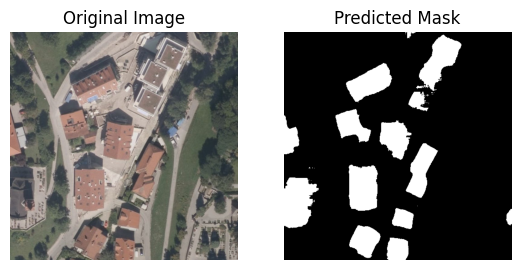

In [12]:
test_image_path = random.choice(list((PATH_TEST_DATASET_PROCESSED / "images").glob("*.png")))

image = tf.io.read_file(str(test_image_path))
image = tf.image.decode_image(image, channels=3)
image = tf.image.resize(image, [PATCH_SIZE, PATCH_SIZE])
image = tf.cast(image, tf.float32) / 255.0
image = tf.expand_dims(image, axis=0)

predicted_mask = loaded_model.predict(image)

predicted_mask = tf.squeeze(predicted_mask, axis=0)
predicted_mask = tf.where(predicted_mask > 0.5, 1.0, 0.0) 

mask_filename = test_image_path.name.replace(".png", "_gt.png") 
ground_truth_mask_path = PATH_TRAIN_DATASET_PROCESSED / "gt" / test_image_path.name

ground_truth_mask = None
if ground_truth_mask_path.exists():
    mask_data = tf.io.read_file(str(ground_truth_mask_path))
    ground_truth_mask = tf.image.decode_image(mask_data, channels=1)
    ground_truth_mask = tf.image.resize(ground_truth_mask, [PATCH_SIZE, PATCH_SIZE])
    ground_truth_mask = tf.cast(ground_truth_mask, tf.float32) / 255.0

# Visualize the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(tf.squeeze(image, axis=0))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(tf.squeeze(predicted_mask), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

if ground_truth_mask is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(ground_truth_mask), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

plt.show()